### 한강대교 유량 결측치 처리
1. 사용할 컬럼: 자기 자신 -> 청담대교 수위 -> 행주대교 유량 -> 잠수교 수위 -> 청담대교 유량 -> 광진교 유량 -> 한강대교 수위 -> 강화대교 조위 -> 방류량 -> 강수량... -> 행주대교 수위
2. 그런데 이 순서는 모델의 행동을 설명하는 것이지 인과관계를 반드시 보장한다고 할 수는 없음...

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

import time
from glob import glob
from tqdm import tqdm

import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras import backend as K
# from keras.utils import plot_model

from keras.layers import Activation, Dense, LSTM, GRU, Bidirectional, AveragePooling1D, GlobalAveragePooling1D, Dropout, Flatten, BatchNormalization, TimeDistributed, Input, Reshape, RepeatVector, Concatenate, GlobalMaxPooling1D 
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D


#GPU 자원이 부족
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
import os
os.chdir('/content/drive/MyDrive/신입기수 프로젝트/Dataset/')

In [4]:
# 결측치 처리한 수위4개+유량1개 데이터셋 가져오기
raw_data = pd.read_csv('Copy of 0827 광진행주유량수위x4.csv', encoding = 'cp949')

# 6912개 수위데이터 + 한강대교_수위 데이터셋 가져오기
newdata5 = pd.read_csv('newdata5.csv', encoding = 'cp949')

# 한강대교 수위 컬럼 추가
raw_data = pd.concat([raw_data, newdata5['한강대교_유량']], axis = 1)

# 6912개 수위 데이터 replace
raw_data.iloc[-6912:, [2, 3, 4, 5]] = newdata5.iloc[-6912:, [-4, -3, -2, -1]]

In [5]:
raw_data

,광진교_수위,행주대교_유량,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위,한강대교_유량
0,1.20,540.18,310.7,300.2,290.0,275.3,729.80
1,1.20,540.18,314.7,300.2,290.0,275.3,731.48
2,1.20,540.18,313.7,301.2,290.0,275.3,726.42
3,1.20,552.17,311.7,301.2,290.0,276.3,726.42
4,1.20,564.29,311.7,301.2,291.0,277.3,707.17
...,...,...,...,...,...,...,...
276331,1.12,974.40,288.0,295.0,299.0,306.0,-456.41
276332,1.12,1006.88,287.0,303.0,304.0,308.0,-717.30
276333,1.12,1039.90,299.0,307.0,309.0,310.0,-843.37
276334,1.12,1073.46,309.0,311.0,314.0,312.0,-1023.37


In [6]:
x = raw_data[['청담대교_수위', '잠수교_수위',	'한강대교_수위',	'행주대교_유량', '한강대교_유량']]

In [7]:
x

,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_유량,한강대교_유량
0,310.7,300.2,290.0,540.18,729.80
1,314.7,300.2,290.0,540.18,731.48
2,313.7,301.2,290.0,540.18,726.42
3,311.7,301.2,290.0,552.17,726.42
4,311.7,301.2,291.0,564.29,707.17
...,...,...,...,...,...
276331,288.0,295.0,299.0,974.40,-456.41
276332,287.0,303.0,304.0,1006.88,-717.30
276333,299.0,307.0,309.0,1039.90,-843.37
276334,309.0,311.0,314.0,1073.46,-1023.37


In [8]:
# 정규화
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

input_x_regular = x.copy()

for i in range(len(x.columns)):
    scaler = MinMaxScaler()                       #StandardScaler() , MinMaxScaler() , RobustScaler()
    a=np.array(input_x_regular.iloc[:,i])
    tmp_x = scaler.fit_transform(a.reshape(-1,1))
    input_x_regular.iloc[:,i] = tmp_x

# 원하는 칼럼명 입력하기

In [9]:
#ydata = raw_data[['현재수위','유입량','저수량','공용량','방류량','강화대교_조위','청담대교_유량','잠수교_유량','한강대교_유량']]
y = raw_data['한강대교_유량']

# 원하는 칼럼명 입력하기

In [10]:
input_regular = pd.concat([input_x_regular, y], axis = 1)
input_regular

,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_유량,한강대교_유량,한강대교_유량
0,0.049611,0.060000,0.051621,0.011070,0.147596,729.80
1,0.053502,0.060000,0.051621,0.011070,0.147654,731.48
2,0.052529,0.061111,0.051621,0.011070,0.147478,726.42
3,0.050584,0.061111,0.051621,0.011475,0.147478,726.42
4,0.050584,0.061111,0.052821,0.011883,0.146810,707.17
...,...,...,...,...,...,...
276331,0.027529,0.054222,0.062425,0.025719,0.106425,-456.41
276332,0.026556,0.063111,0.068427,0.026815,0.097370,-717.30
276333,0.038230,0.067556,0.074430,0.027929,0.092994,-843.37
276334,0.047957,0.072000,0.080432,0.029061,0.086747,-1023.37


# 원하는 칼럼명 입력하기

In [11]:
df_nanindex = pd.read_csv('/content/drive/MyDrive/신입기수 프로젝트/Dataset/rawdata.csv')

nanIndex = df_nanindex[df_nanindex['한강대교_유량'].isnull() == True].index

In [12]:
nanIndex

Int64Index([ 91352,  91353,  91354,  91355,  91356,  91357,  91358,  91359,
             91360,  91361,
            ...
            262125, 262126, 262127, 262128, 262129, 262130, 262131, 262132,
            262133, 262134],
           dtype='int64', length=1279)

In [13]:
from tqdm import tqdm

xdata = []
ydata = []
xdata_idx = []
ydata_idx = [-1]
for i in range(len(input_regular.columns)-1):
    xdata_idx.append(i)

w =  6 #window size

idx = []
for i in range(12):
  idx.append(i*26496)

for i in tqdm(range(11)):
    if i != 10:
        tmp = input_regular[idx[i]:idx[i+1]]
    else:
        tmp = input_regular[idx[i]:]

    for j in range(len(tmp)-w):
        xdata.append(np.array(tmp.iloc[j:j + w, xdata_idx]).astype(float))

    for j in range(w,len(tmp)):
        ydata.append(np.array(tmp.iloc[j, ydata_idx]).astype(float))

100%|██████████| 11/11 [03:07<00:00, 17.07s/it]


In [14]:
print(np.array(xdata).shape)
print(np.array(ydata).shape)

(276270, 6, 5)
(276270, 1)


In [15]:
# 나중에 학습된 모델에 이거 넣어서 predict해서 결측치 채우기
x_real_predict = []
y_real_predict = []

for i in range(len(nanIndex)):
    k = nanIndex[-(i+1)]
    
    x_real_predict.insert(0,(xdata[k - w * (k // 26496 + 1)]))
    y_real_predict.insert(0,(ydata[k - w * (k // 26496 + 1)]))
    
    xdata.pop(k - w * (k // 26496 + 1))
    ydata.pop(k - w * (k // 26496 + 1))

In [16]:
print(np.array(x_real_predict).shape)
print(np.array(y_real_predict).shape)

(1279, 6, 5)
(1279, 1)


In [17]:
print(np.array(xdata).shape)
print(np.array(ydata).shape)

(274991, 6, 5)
(274991, 1)


In [18]:
pd.DataFrame(ydata).isnull().sum()

0    0
dtype: int64

In [19]:
xtrain = np.array(xdata[:-50000])
ytrain = np.array(ydata[:-50000])

xtest = np.array(xdata[-50000:])
ytest = np.array(ydata[-50000:])

In [20]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(224991, 6, 5)
(224991, 1)
(50000, 6, 5)
(50000, 1)


## 모델 생성

In [21]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

if 'model_enc_dec_cnn' in locals(): 
    del model_enc_dec_cnn 
if 'history' in locals():
    del history

optimizer = tf.keras.optimizers.Adam(lr=0.01) #기본값 0.001

model_enc_dec_cnn = Sequential()
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=2, padding = 'causal', activation='relu', input_shape=(w, xtrain.shape[2])))
#model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=2, padding = 'causal', activation='relu'))
#model_enc_dec_cnn.add(MaxPooling1D(pool_size=2))
model_enc_dec_cnn.add(Flatten())

model_enc_dec_cnn.add(RepeatVector(1))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
# model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
# model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
# model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu'))

model_enc_dec_cnn.add(Dense(100, activation='relu'))
model_enc_dec_cnn.add(Dense(1))

model_enc_dec_cnn.compile(loss=root_mean_squared_error, optimizer=optimizer, metrics =["accuracy"])

model_enc_dec_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6, 64)             704       
                                                                 
 flatten (Flatten)           (None, 384)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 1, 384)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 1, 200)            468000    
                                                                 
 lstm_1 (LSTM)               (None, 1, 200)            320800    
                                                                 
 lstm_2 (LSTM)               (None, 200)               320800    
                                                        

In [22]:
# plot_model(model=model_enc_dec_cnn, show_shapes=True)

In [23]:
epochs = 100
batch_size = xtrain.shape[0] // 1000
validation = 0.2

checkpoint_callback = ModelCheckpoint(filepath='best_model.h5', save_weights_only=False, monitor='val_loss',
                                         mode='min', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=10, mode='min')
rlrop_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, mode='min', patience=3, min_lr=0.001)

In [24]:
## 학습

history = model_enc_dec_cnn.fit(xtrain, ytrain, verbose=1, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])

Epoch 1/100
804/804 [==============================] - 41s 46ms/step - loss: 224.0529 - accuracy: 1.6667e-04 - val_loss: 91.5911 - val_accuracy: 1.7778e-04 - lr: 0.0100
Epoch 2/100
804/804 [==============================] - 39s 48ms/step - loss: 104.0648 - accuracy: 2.0001e-04 - val_loss: 70.1412 - val_accuracy: 8.8891e-05 - lr: 0.0100
Epoch 3/100
804/804 [==============================] - 37s 45ms/step - loss: 92.6602 - accuracy: 2.8890e-04 - val_loss: 71.0056 - val_accuracy: 8.8891e-05 - lr: 0.0100
Epoch 4/100
804/804 [==============================] - 37s 46ms/step - loss: 81.2765 - accuracy: 3.0557e-04 - val_loss: 67.7562 - val_accuracy: 6.6668e-05 - lr: 0.0100
Epoch 5/100
804/804 [==============================] - 38s 48ms/step - loss: 76.6934 - accuracy: 2.9446e-04 - val_loss: 109.2430 - val_accuracy: 0.0000e+00 - lr: 0.0100
Epoch 6/100
804/804 [==============================] - 37s 46ms/step - loss: 73.5140 - accuracy: 2.8335e-04 - val_loss: 65.2561 - val_accuracy: 3.3334e-04 - 

In [25]:
## 평가

keras_model_best = keras.models.load_model('best_model.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error})

yhat = keras_model_best.predict(xtest, verbose=1)

yhat

keras_model_best.evaluate(xtest,ytest)

1563/1563 [==============================] - 9s 6ms/step - loss: 44.1720 - accuracy: 2.4000e-04


[44.171974182128906, 0.00023999999393709004]

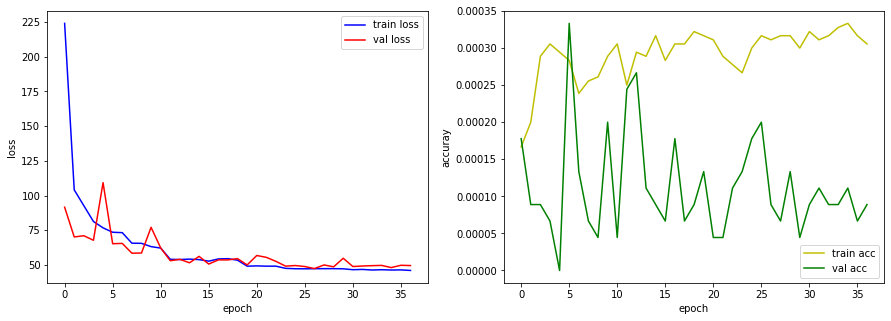

In [26]:
## 학습 과정 시각화

fig, loss_ax = plt.subplots(1, 2)
fig.set_size_inches((15,5))

loss_ax[0].plot(history.history['loss'], 'b', label='train loss')
loss_ax[0].plot(history.history['val_loss'], 'r', label='val loss')

loss_ax[1].plot(history.history['accuracy'], 'y', label='train acc')
loss_ax[1].plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax[0].set_xlabel('epoch')
loss_ax[0].set_ylabel('loss')
loss_ax[1].set_xlabel('epoch')
loss_ax[1].set_ylabel('accuray')

loss_ax[0].legend(loc='upper right')
loss_ax[1].legend(loc='lower right')

plt.show()

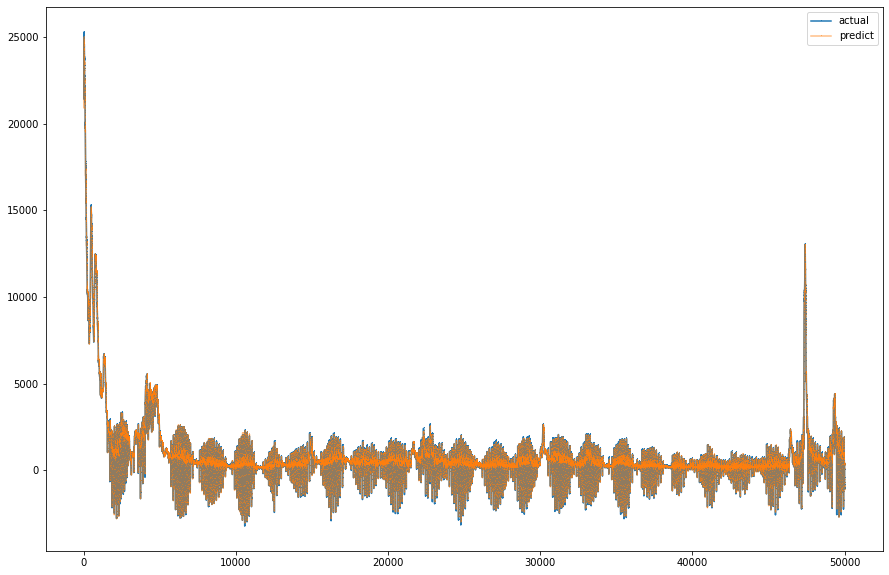

In [27]:
## 결과 시각화

tl_predict = np.array(yhat)

#결과 시각화
plt.figure(figsize=(15,10))
plt.plot(ytest, marker = ",", label = "actual")
plt.plot(tl_predict, marker = ",", label="predict", alpha = 0.5)
plt.legend(prop={'size':10})  

plt.show()

In [28]:
## 점수 확인
print("RMSE : ",float(root_mean_squared_error(ytest, tl_predict)))

RMSE :  49.51231738676866


## 파일 저장

In [29]:
print(len(yhat))
print(len(nanIndex))

50000
1279


In [30]:
x_real_predict = np.array(x_real_predict)
y_real_hat = keras_model_best.predict(x_real_predict, verbose = 1)

40/40 [==============================] - 0s 5ms/step


In [34]:
root_mean_squared_error(y_real_predict, y_real_hat) #y_real_predict도 예측값밖에 없어서 의미없긴 하지만 얼마나 달라졌는지 보고 싶어서

<tf.Tensor: shape=(), dtype=float64, numpy=44.92702085587341>

In [35]:
print(len(y_real_hat))
print(len(nanIndex))

1279
1279


In [36]:
for i in range(len(nanIndex)):
    raw_data['한강대교_유량'].iloc[nanIndex[i]] = np.float64(y_real_hat[i])

In [37]:
raw_data['한강대교_유량'].to_csv('/content/drive/MyDrive/신입기수 프로젝트/Dataset/newdata7_한강대교_유량_광진교_제외.csv', index = False, encoding = 'cp949')